# FRC Match Simulator
#### by Mark JP Sanchez

## Table of Contents
0. What is FRC?
1. Introduction
2. Initial Data
3. Data Cleaning and Engineering
4. Exploratory Data Analysis (EDA)
5. The Predictive Models
6. Conclusion
7. Seeing How Our Friends Are Doing

# 0.What is FRC?
FIRST Robotics Competition (FRC) is an international high school robotics competition which is run by FIRST. High schoolers are tasked with building a robot in 6 weeks for a game that changes every year. Sometimes robots are required to climb and scale structures, sometimes they are required shoot plastic balls into small opening and sometimes they are required to place boxes on a giant scale.

The way each competition works is that all the teams participating face each other off in a round robin style tournament where they will be partnered up with two other random teams to face another alliance of 3. After the round robin tournament, the top 8 teams will be given a chance to choose two other teams to form their own alliance. These alliances will then face each other in an elimination style tournament where the last remaining alliance are the champions of the competition.

More info can be found here: https://www.firstinspires.org/

## 1.Introduction

We will use various predictive models to predict the outcome of matches. This may help teams with choosing their alliance partners. All data is gathered from https://www.thebluealliance.com/apidocs/v3. We will explore the data and engineer some features to help our predictive models. All the code for gathering the data and combining the data https://github.com/Mark-of-JP/FRC-Match-Simulator.

The result of this project is a model that predicts the outcome of a match with around 73% accuracy.

## 2.The Initial Data
From *data_collector.py* we gather data for matches, awards and teams. We then put that data into three csv's. There is a lot of unneeded data which we will clean out later.

First we should run the required imports for any data science project:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing, metrics

Here is the data gotten from */teams* endpoint of the api:

In [2]:
#Dropping the Unnamed column since it is just a column container the index of each row
team_df = pd.read_csv('raw_frc_teams.csv').drop(columns=['Unnamed: 0'])
team_df.head()

,address,city,country,gmaps_place_id,gmaps_url,home_championship,key,awards,lat,lng,location_name,motto,name,nickname,postal_code,rookie_year,school_name,state_prov,team_number,website
0,NaN,Pontiac,USA,NaN,NaN,{'2020': 'Detroit'},frc1,36,NaN,NaN,NaN,NaN,FCA Foundation/Hirotec America/Molex&Oakland S...,The Juggernauts,48340,1997.0,Oakland Schools Technical Campus Northeast,Michigan,1,http://www.juggernautsteam1.com
1,NaN,Van Nuys,USA,NaN,NaN,{'2020': 'Houston'},frc4,12,NaN,NaN,NaN,NaN,Boston Scientific/Aerojet Rocketdyne/Raytheon/...,Team 4 ELEMENT,91406,1997.0,High Tech Los Angeles,California,4,http://www.team4element.com
2,NaN,Melvindale,USA,NaN,NaN,NaN,frc5,10,NaN,NaN,NaN,NaN,Ford FIRST Robotics & Melvindale High School,Robocards,NaN,1998.0,NaN,MI,5,http://www.robocards.org
3,NaN,Plymouth,USA,NaN,NaN,NaN,frc6,1,NaN,NaN,NaN,NaN,ATK (Alliant Techsystems) & Hopkins High School,The CogSquad,NaN,1994.0,NaN,MN,6,http://www.cogsquad.org
4,NaN,Baltimore,USA,NaN,NaN,NaN,frc7,8,NaN,NaN,NaN,NaN,Lockheed Martin/Northrop Grumman/Oak Harbor Ma...,Team007,NaN,NaN,NaN,MD,7,http://www.team007.org


Here is the data gotten from the */event/{event_key}/matches* endpoint of the api. All the event keys were collected beforehand using the same api:

In [3]:
#Dropping the Unnamed column since it is just a column container the index of each row
match_df = pd.read_csv('raw_frc_matches.csv').drop(columns=['Unnamed: 0'])
match_df.head()

,actual_time,red_score,red_0,red_1,red_2,blue_score,blue_0,blue_1,blue_2,comp_level,event_key,key,match_number,predicted_time,set_number,time,winning_alliance
0,NaN,32,frc111,frc175,NaN,20,frc22,frc45,NaN,ef,2000cmp,2000cmp_ef1m1,1,NaN,1,NaN,red
1,NaN,31,frc80,frc111,NaN,37,frc45,frc340,NaN,ef,2000cmp,2000cmp_ef1m2,2,NaN,1,NaN,blue
2,NaN,34,frc80,frc111,NaN,28,frc45,frc340,NaN,ef,2000cmp,2000cmp_ef1m3,3,NaN,1,NaN,red
3,NaN,13,frc47,frc312,NaN,23,frc126,frc131,NaN,ef,2000cmp,2000cmp_ef3m1,1,NaN,3,NaN,blue
4,NaN,14,frc312,frc201,NaN,28,frc126,frc131,NaN,ef,2000cmp,2000cmp_ef3m2,2,NaN,3,NaN,blue


Here is the data gotten from the */team/{team_key}/awards* endpoint of the api. All the team keys were collected beforehand using the same api:

In [4]:
#Dropping the Unnamed column since it is just a column container the index of each row
awards_df = pd.read_csv('raw_frc_awards.csv').drop(columns=['Unnamed: 0'])
awards_df.head()

,recipient,award_type,event_key,year
0,frc1,44,1998cmp,1998
1,frc1,17,1998mi,1998
2,frc1,1,1999cmp,1999
3,frc1,20,1999il,1999
4,frc1,2,1999mi,1999


## 3.Data Cleaning and Combining
With all of our data collected it is now time to combine all of our data for our use case. The code use to generate the use case csv can be found in *data_cleaner.py*.

Here is the result of that code: (Note that if red_won is 1 then the red alliance won the match)

In [5]:
#Reads the csv and drops the index column
df = pd.read_csv('frc_use_case.csv').drop(columns=["Unnamed: 0"])
df = df.dropna()
df

,red_score,red_0,red_1,red_2,blue_score,blue_0,blue_1,blue_2,event_key,key,...,blue_avg_winrate_season,blue_avg_games_played_season,avg_match_awards_diff,avg_other_awards_diff,avg_winrate_diff,avg_games_played_diff,avg_age_diff,avg_winrate_diff_season,avg_games_played_diff_season,red_avg_points_higher
0,157,frc2013,frc4334,frc4625,117,frc4613,frc6082,frc6178,2016abca,2016abca_f1m1,...,0.000000,0.000000,3.333333,6.000000,0.000000,0.000000,4.333333,0.000000,0.000000,0
1,169,frc2013,frc4334,frc4625,149,frc4613,frc6082,frc6178,2016abca,2016abca_f1m2,...,0.000000,1.000000,3.333333,6.000000,1.000000,0.000000,4.333333,1.000000,0.000000,1
2,140,frc2013,frc4334,frc4625,90,frc1482,frc4010,frc4604,2016abca,2016abca_qf1m1,...,0.000000,0.000000,3.333333,4.000000,1.000000,2.000000,-1.000000,1.000000,2.000000,0
3,135,frc2013,frc4334,frc4625,126,frc1482,frc4010,frc4604,2016abca,2016abca_qf1m2,...,0.000000,1.000000,3.333333,4.000000,1.000000,2.000000,-1.000000,1.000000,2.000000,1
4,113,frc5897,frc5725,frc5630,106,frc216,frc4634,frc5015,2016abca,2016abca_qf2m1,...,0.000000,0.000000,-2.333333,-0.333333,0.000000,0.000000,-6.666667,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,9,frc3467,frc501,frc3986,12,frc2713,frc151,frc4909,2020week0,2020week0_qm9,...,0.194444,4.666667,4.333333,4.000000,0.090686,36.666667,-3.000000,0.250000,0.000000,1
72787,58,frc5687,frc1519,frc1721,95,frc1153,frc5962,frc238,2020week0,2020week0_sf1m1,...,0.494048,7.333333,9.333333,4.000000,0.131672,54.666667,-2.666667,0.305952,-2.333333,0
72788,82,frc5687,frc1519,frc1721,87,frc1153,frc5962,frc238,2020week0,2020week0_sf1m2,...,0.555556,8.333333,9.333333,4.000000,0.127324,54.666667,-2.666667,0.111111,-2.333333,0
72789,38,frc1073,frc811,frc58,86,frc3117,frc4041,frc501,2020week0,2020week0_sf2m1,...,0.809524,7.000000,5.333333,11.000000,0.009610,53.333333,7.000000,-0.087302,-1.000000,0


### How was this data cleaned and combine?
#### Removing unneeded colums
First of all, columns were removed from each of the data sets like the gmaps_url columns from teams data set due to either being irrelevant for our use case or had too many missing values.

We also removed the matches that only contained less than 3 people per alliance since it seems like the 3v3 system wasn't adopted until later years so it wouldn't make sense to train a model on outdated data.

Matches container demo robots such as the frc team with the team key 'frc9999' were also removed since those matches might not be indicative of an actual frc match.

In [6]:
print(str(team_df['gmaps_url'].isna().sum()) + " rows don't have a gmaps_url out of " + str(len(team_df)) + ' teams.')
print(str(match_df['red_2'].isna().sum()) + " matches did not have a 3rd red alliance member.")

7345 rows don't have a gmaps_url out of 7345 teams.
8202 matches did not have a 3rd red alliance member.


#### Considering Our Use Case
Next we thought about our use case and realized that for different matches, the same team might have different stats such as the amount of awards they have received due to the passage of time. So we dropped all the rows that did not contain any time. Looking at what we have left, we dropped the rows that did were held on years that had a large majority of its matches missing due to time.

This left us with matches from 2016-2020.

In [7]:
print('We came from ' + str(len(match_df)) + ' matches to ' + str(len(df)) + ' matches after dropping everything.')

We came from 163001 matches to 72790 matches after dropping everything.


#### Iterating Through The Matches
After we had valid match data we then sorted them in ascending order according to their time and we collected and inserted data for each match. For each match we added each alliance's average winrate and then applied the results of those matches to our current winrate calculations. We did the same thing for things such as the average number of matches.

We seperated this data into overall team stats and the team stat for the season.
#### And the Award Goes To
For the awards each team has garnered we decided to split them up into two sections. The match awards, which were awards given to you because of your success in the matches, and the other awards. Chairman's award, Winner award, Finalist award, Rookie All Star award and the Highest Rookie Seed award were considered as the match awards. The other awards include things like the Entrepreneurship award and the Safety award.

To get the award data for each match we first gave all of the teams the awards they got before 2016. Each match has an event key that designates what event those matches were taken place at. So while we iterate through the matches, once we see that an event has ended we then award all the teams the awards they would have gotten for that event since awards are given after an event.
#### A Pointer on Points
One difficulty that was being faced was the fact that every year a new game would be played which meant that the average number of points and the max number of points a team can get changed every year. To somewhat counter this problem, average points between teams were represented as a ratio between the average points scored by the red alliance and the average points scored by the blue alliance. This way if an alliance beats their opponent by having double their points, it will be represented no matter what the year.

red_points_ratio: (avg score from the current red alliance for the season)/(avg score from the current blue alliance for the season)

*Note: Average score for an alliance is calculated by getting each teams average score for the season then averaging that score out for the alliance*

## 4.Exploratory Data Analysis (EDA)
Now that our use case data is set up and ready lets see what kind of information it can give us.

In [8]:
#Dropping the year since describing them won't really mean anything
df.drop(columns=['year']).describe()

,red_score,blue_score,red_won,red_avg_match_awards,red_avg_other_awards,blue_avg_match_awards,blue_avg_other_awards,red_avg_winrate,red_avg_games_played,blue_avg_winrate,...,blue_avg_winrate_season,blue_avg_games_played_season,avg_match_awards_diff,avg_other_awards_diff,avg_winrate_diff,avg_games_played_diff,avg_age_diff,avg_winrate_diff_season,avg_games_played_diff_season,red_avg_points_higher
count,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,...,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000
mean,167.554994,161.574639,0.528864,4.640582,7.315684,4.148459,6.749187,0.489217,79.825297,0.479864,...,0.427162,6.155085,0.492123,0.566497,0.009353,3.017122,0.155072,0.029413,0.102368,0.486853
std,124.983631,119.898561,0.499170,4.791885,6.598251,4.164443,6.093465,0.096489,56.754301,0.095347,...,0.212812,4.117126,5.471719,7.763112,0.123019,40.835643,4.560748,0.297253,1.484581,0.499831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-35.333333,-40.333333,-1.000000,-257.333333,-19.666667,-1.000000,-6.000000,0.000000
25%,64.000000,62.000000,0.000000,1.333333,2.333333,1.333333,2.000000,0.437286,34.666667,0.433152,...,0.333333,2.666667,-2.000000,-3.666667,-0.058281,-16.333333,-2.666667,-0.111111,-1.000000,0.000000
50%,116.000000,111.000000,1.000000,3.000000,5.666667,3.000000,5.000000,0.492049,68.666667,0.486156,...,0.459635,5.666667,0.333333,0.333333,0.008162,1.666667,0.000000,0.000000,0.000000,0.000000
75%,260.000000,255.000000,1.000000,6.333333,10.666667,5.666667,9.666667,0.545452,114.000000,0.536401,...,0.556980,9.000000,2.666667,4.666667,0.074274,22.000000,3.000000,0.139361,1.000000,1.000000
max,987.000000,1080.000000,1.000000,43.666667,49.000000,42.000000,53.000000,1.000000,345.333333,1.000000,...,1.000000,24.000000,37.000000,41.333333,1.000000,236.000000,19.000000,1.000000,6.000000,1.000000


All the data seems to be uniformly distributed though we do see some examples of extreme outliers such as the difference between average number of games played.

Looking at the red_won column we see that the mean is 0.53 which might indicate that red wins more often then blue.

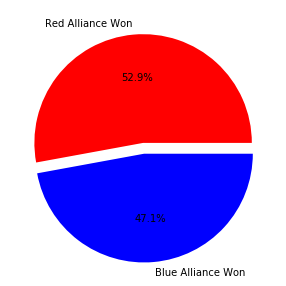

In [9]:
pie_chart_values = [len(df[df.red_won == 1]), len(df[df.red_won != 1])]
labels = ['Red Alliance Won', 'Blue Alliance Won']
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.pie(pie_chart_values, labels=labels, explode=[0, 0.1], autopct='%1.1f%%', colors=['red', 'blue'])

plt.show()

It looks like in our data set, the red alliance wins more often then the blue alliance. This discrepancy might exist due to the fact that the first seeded team in a competition is always the red alliance during a competition. Though the data set is somewhat imbalanced, the discrepancy is not extreme enough for us to want to fix it which may lose the accuracy of our models.

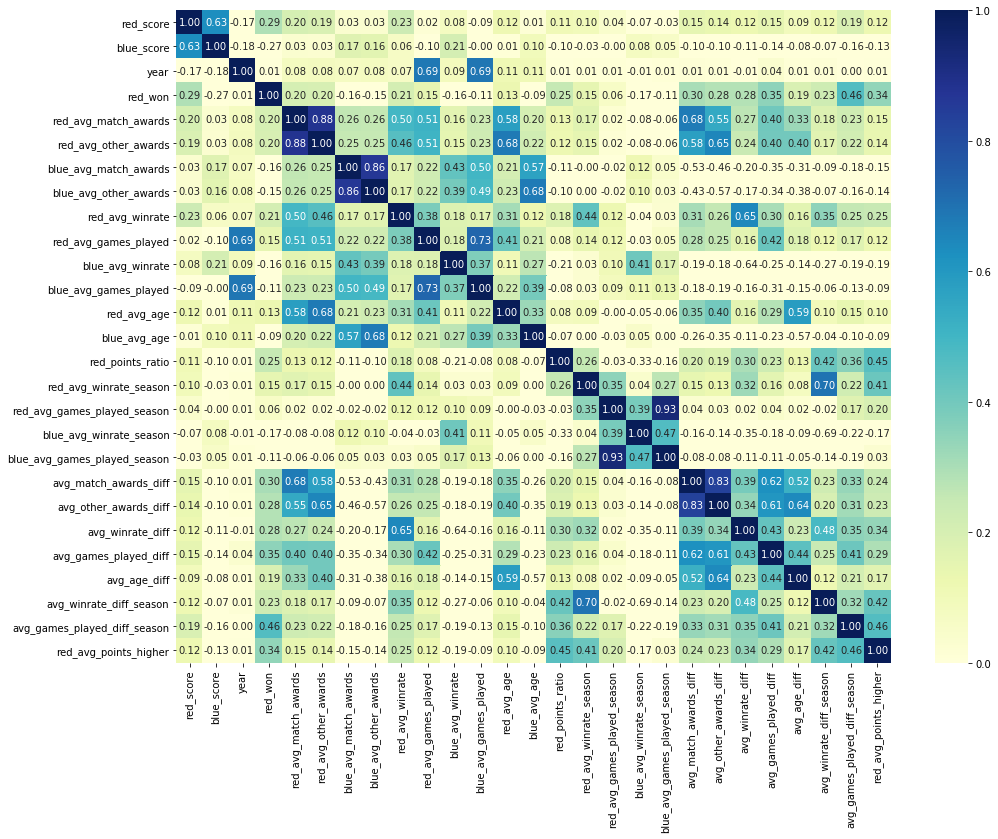

In [10]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0)

The correlation heatmap shows the linear correlation between two values. The closer the absolute value of a correlation is to 1 the stronger the correlation is. 

Do be wary about some values in the heat map as they may be misleading. For example the blue score and red score seem to be strongly postively correlated to each other and that does not mean that the higher the blue score, the higher the red score will be. Since each year the game is different, the average number of points an alliance gains each year is different.

We can take a look at some of the correlations and see if we can find anything to make our models.

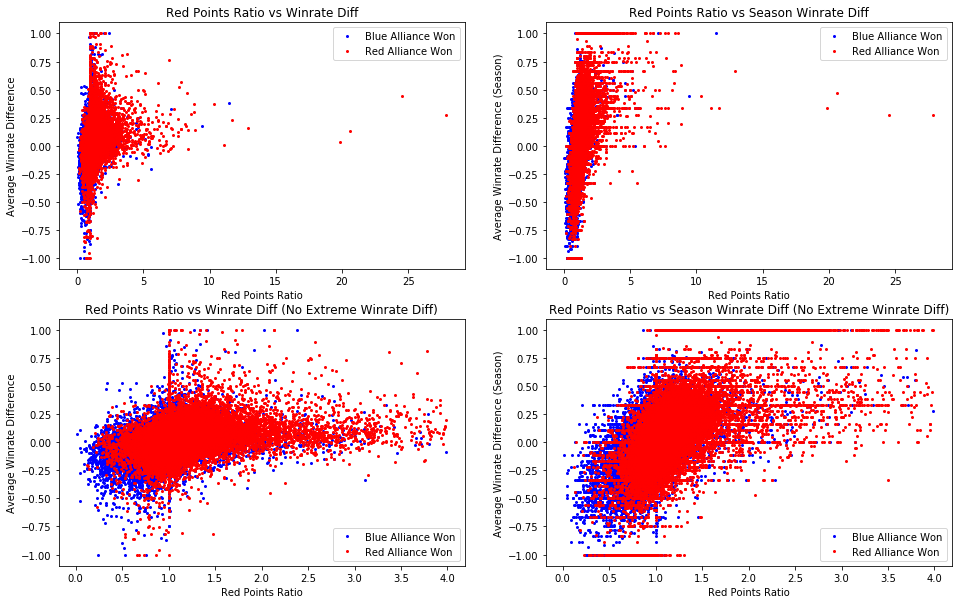

In [22]:
groups = df.groupby('red_won')

fig, ax = plt.subplots(2, 2, figsize=(16,10))

#General Scatter Plot
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 0].plot(group.red_points_ratio, group.avg_winrate_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 0].legend()
ax[0, 0].legend()
ax[0, 0].legend()
ax[0, 0].set_xlabel('Red Points Ratio')
ax[0, 0].set_ylabel('Average Winrate Difference')
ax[0, 0].set_title('Red Points Ratio vs Winrate Diff')


#Getting rid of the extreme cases
for winner, group in groups:
    group = group[group.red_points_ratio < 4]
    
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 0].plot(group.red_points_ratio, group.avg_winrate_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 0].legend()
ax[1, 0].legend()
ax[1, 0].set_xlabel('Red Points Ratio')
ax[1, 0].set_ylabel('Average Winrate Difference')
ax[1, 0].set_title('Red Points Ratio vs Winrate Diff (No Extreme Winrate Diff)')

#Seasonal Scatter Plot
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 1].plot(group.red_points_ratio, group.avg_winrate_diff_season, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 1].legend()
ax[0, 1].legend()
ax[0, 1].set_xlabel('Red Points Ratio')
ax[0, 1].set_ylabel('Average Winrate Difference (Season)')
ax[0, 1].set_title('Red Points Ratio vs Season Winrate Diff')

#Getting rid of the extreme cases (Seasonal)
for winner, group in groups:
    group = group[group.red_points_ratio < 4]
    
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 1].plot(group.red_points_ratio, group.avg_winrate_diff_season, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 1].legend()
ax[1, 1].set_xlabel('Red Points Ratio')
ax[1, 1].set_ylabel('Average Winrate Difference (Season)')
ax[1, 1].set_title('Red Points Ratio vs Season Winrate Diff (No Extreme Winrate Diff)')

plt.show()

Comparing the red points ratio to the average winrate difference we see that even though there is a lot of noise in the middle, there are two noticeable sections that are forming. When see that there are a lot of blue alliance wins clustered near the bottom-left of each graph. We can also see that the greater the red points ratio is, the more often red alliance wins. Especially since all the extreme red points ration values depict red alliance winning.

Seeing that these two variables start to group the alliance wins together we can see that there is some hope in being able to create a predictive model and we can get a clue as to what models might be useful for our use case.

## 5.The Predictive Models
Looking at the data and the correlations we found we can choose some independent variables for our models. These independent variables will hopefully influence our dependent variable which is *red_won*

In [12]:
independent_variables = ['red_points_ratio', 'avg_match_awards_diff', 'avg_winrate_diff', 
                         'avg_games_played_diff', 'avg_age_diff', 'avg_winrate_diff_season',
                         'avg_games_played_diff_season']

train_df = df[independent_variables]
train_df.head()

,red_points_ratio,avg_match_awards_diff,avg_winrate_diff,avg_games_played_diff,avg_age_diff,avg_winrate_diff_season,avg_games_played_diff_season
0,1.000000,3.333333,0.0,0.0,4.333333,0.0,0.0
1,1.341880,3.333333,1.0,0.0,4.333333,1.0,0.0
2,1.000000,3.333333,1.0,2.0,-1.000000,1.0,2.0
3,1.725926,3.333333,1.0,2.0,-1.000000,1.0,2.0
4,1.000000,-2.333333,0.0,0.0,-6.666667,0.0,0.0


Now that we have our independent variables, we need to split the data into a train and test split. We will randomly select 75% of the data we have and train our models on them. We will then see how accurate these models are by comparing the results to our remain 25% of data.

In [13]:
X = train_df
#The data frame is being used here so that we can check on how accurate the model is for specific teams are later on
y = df

#Splitting our data into a test and train split
X_train,X_test,y_train_prime,y_test_prime = train_test_split(X,y,test_size=0.25, random_state=5406)

y_train, y_test = y_train_prime['red_won'], y_test_prime['red_won']

### Our Models
We will be using four classification models which are Logistic Regression, Naive Bayes, K Nearest Neighbours and Random Forest.

In [14]:
#Logistic Regression Model
lr = LogisticRegression(max_iter=4000)
lr.fit(X_train, y_train)

y_lr_pred = lr.predict(X_test)

In [15]:
#Random Forest
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_clf_pred = clf.predict(X_test)

In [16]:
#K Nearest Neighbours (K is small to account for rookie teams who do amazing since they won't have many accolades)
knn = KNeighborsClassifier(n_neighbors=77)
knn.fit(X_train, y_train)

y_knn_pred = knn.predict(X_test)

In [17]:
#Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

y_nb_pred = nb.predict(X_test)

Now that our models have been created and fitted let us see how well they did

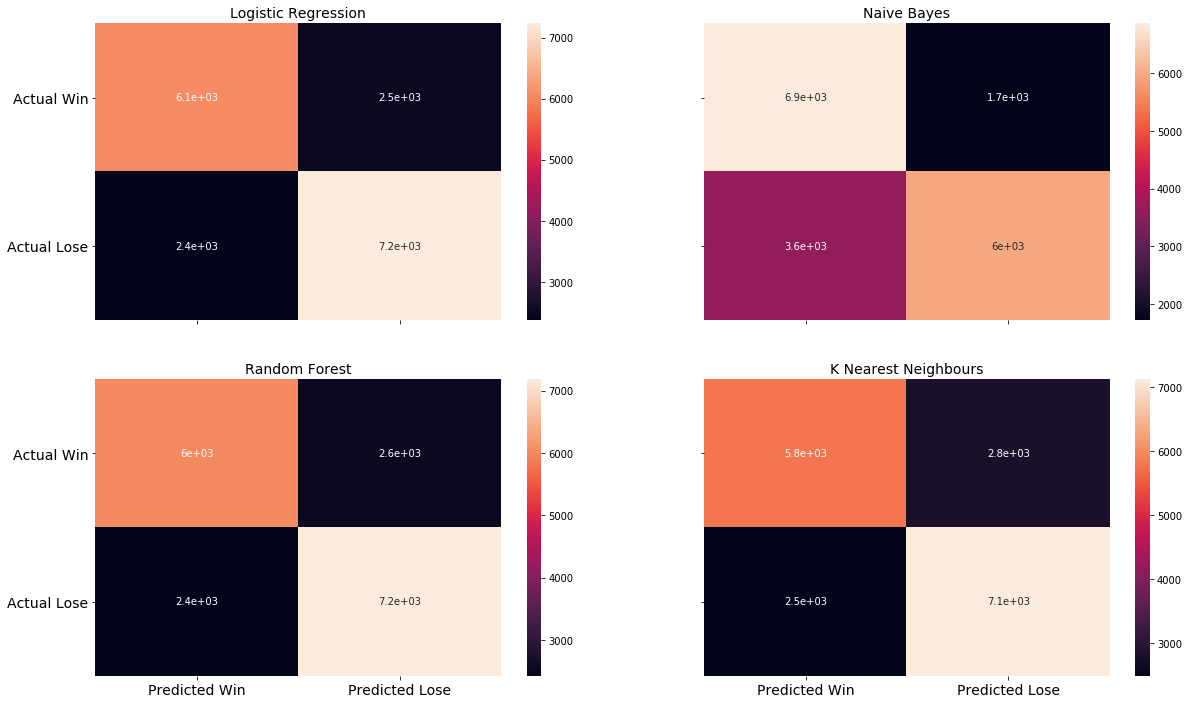

In [18]:
#Create confusion matrices
lr_cf = metrics.confusion_matrix(y_test, y_lr_pred)
clf_cf = metrics.confusion_matrix(y_test, y_clf_pred)
knn_cf = metrics.confusion_matrix(y_test, y_knn_pred)
nb_cf = metrics.confusion_matrix(y_test, y_nb_pred)

#Create foundation to display 4 plots
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

#Display heat maps
sns.heatmap(lr_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title('Logistic Regression', fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14)
ax[0, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(clf_cf, ax=ax[1][0], annot=True)
ax[1, 0].set_title('Random Forest', fontsize=14)
ax[1, 0].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(nb_cf, ax=ax[0][1], annot=True)
ax[0, 1].set_title('Naive Bayes', fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

sns.heatmap(knn_cf, ax=ax[1][1], annot=True)
ax[1, 1].set_title('K Nearest Neighbours', fontsize=14)
ax[1, 1].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

plt.show()

In [19]:
#Logistic Regression Report
print('Logistic Regression:')
print(metrics.classification_report(y_test, y_lr_pred))

#Random Forest Report
print('\nRandom Forest:')
print(metrics.classification_report(y_test, y_clf_pred))

#Naive Bayes Report
print('\nNaive Bayes:')
print(metrics.classification_report(y_test, y_nb_pred))

#K Nearest Neighbours Report
print('\nK Nearest Neighbours:')
print(metrics.classification_report(y_test, y_knn_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      8590
           1       0.74      0.75      0.75      9608

    accuracy                           0.73     18198
   macro avg       0.73      0.73      0.73     18198
weighted avg       0.73      0.73      0.73     18198


Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      8590
           1       0.74      0.75      0.74      9608

    accuracy                           0.73     18198
   macro avg       0.72      0.72      0.72     18198
weighted avg       0.73      0.73      0.73     18198


Naive Bayes:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      8590
           1       0.78      0.62      0.69      9608

    accuracy                           0.71     18198
   macro avg       0.72      0.71      0.71     18198
weighted avg       0.72

Looking at the classification report we see that our most accurate models are the Random Forest model and the Logistic Regression model. We see that the two models give us more or less the same results except that our Logistic Regression model is better slightly better at catching all of the losses (recall score for 0).

The Naive Bayes model seems to actually be the best at catching all of the losses with a recall score of 80% and it actually does the best when predicting losses as shown by its f1-score. Though its ability to predict losses better comes at a cost of being the worst when it comes to predicting wins.

## 6.Conclusion
From exploring the data and comparing models we seem to be able to see which model works best for predicting match outcomes. The Logistic Regression model we created appears to be the most accurate being 73% accurate.

Now this model definitely does not replace scouting out other teams and doing your own research especially due to its accuracy but if you are stuck choosing between two teams then the model is technically better than a coin flip!

## 7.Seeing How Our Friends Are Doing
Since we have found the model, let us see how well it did on 4 arbitrary (they are not arbitrary) teams during my last year in robotics.

C:\Users\DarkL\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


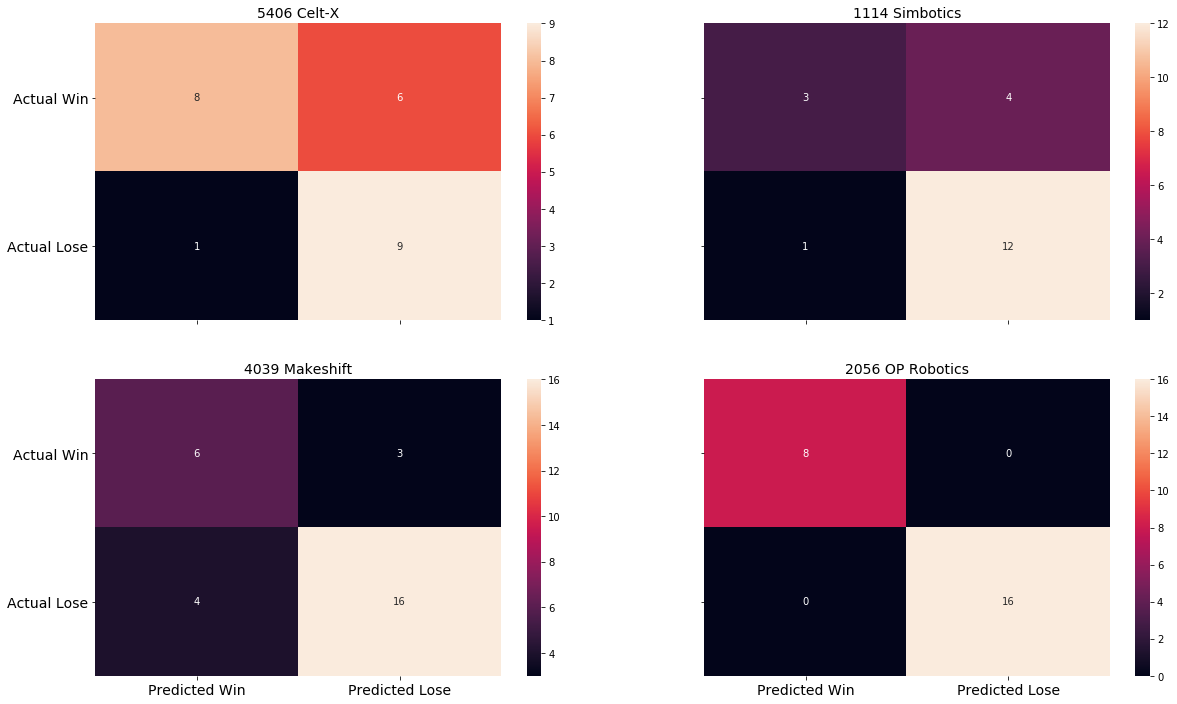

In [20]:
def get_team_test(team_key):
    team_test_df = y_test_prime[(df.red_0 == team_key) | (df.red_1 == team_key) | (df.red_2 == team_key) | (df.blue_0 == team_key) | (df.blue_1 == team_key) | (df.blue_2 == team_key)]
    return team_test_df[team_test_df.year == 2018]

#Get the test values from TOTALLY ARBITRARY teams
frc5406_test = get_team_test('frc5406')
frc4039_test = get_team_test('frc4039')
frc1114_test = get_team_test('frc1114')
frc2056_test = get_team_test('frc2056')

#Make predictions
celt_pred = lr.predict(frc5406_test[independent_variables])
make_pred = lr.predict(frc4039_test[independent_variables])
sim_pred = lr.predict(frc1114_test[independent_variables])
op_pred = lr.predict(frc2056_test[independent_variables])

#Create confusion matrices
celt_cf = metrics.confusion_matrix(frc5406_test['red_won'], celt_pred)
make_cf = metrics.confusion_matrix(frc4039_test['red_won'], make_pred)
sim_cf = metrics.confusion_matrix(frc1114_test['red_won'], sim_pred)
op_cf = metrics.confusion_matrix(frc2056_test['red_won'], op_pred)

#Create foundation to display 4 plots
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

#Display heat maps
sns.heatmap(celt_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title('5406 Celt-X', fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14)
ax[0, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(make_cf, ax=ax[1][0], annot=True)
ax[1, 0].set_title('4039 Makeshift', fontsize=14)
ax[1, 0].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(sim_cf, ax=ax[0][1], annot=True)
ax[0, 1].set_title('1114 Simbotics', fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

sns.heatmap(op_cf, ax=ax[1][1], annot=True)
ax[1, 1].set_title('2056 OP Robotics', fontsize=14)
ax[1, 1].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

plt.show()

In [21]:
#Okay accuracy for my old team
print('5406 Accuracy: ' + str(metrics.accuracy_score(frc5406_test['red_won'], celt_pred)))
#Surprisingly good accuracy for our neighbours
print('4039 Accuracy: ' + str(metrics.accuracy_score(frc4039_test['red_won'], make_pred)))
#Once again pretty good accuracy
print('1114 Accuracy: ' + str(metrics.accuracy_score(frc1114_test['red_won'], sim_pred)))
#How!? Like I guess statistically it can be 100% but wow! I guess the model respects the kings.
print('2056 Accuracy: ' + str(metrics.accuracy_score(frc2056_test['red_won'], op_pred)))

5406 Accuracy: 0.7083333333333334
4039 Accuracy: 0.7586206896551724
1114 Accuracy: 0.75
2056 Accuracy: 1.0
